In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Checking the current directory

%pwd

'C:\\Users\\priya'

### Changing the directory

In [3]:
os.chdir(r'A:\Analytix\python projects\insurance claims (case study 3)')

### Import claims_data.csv and cust_data.csv which is provided to you and combine the two datasets appropriately to create a 360-degree view of the data. Use the same for the subsequent questions.

In [51]:
# Importing the required datsets

claim = pd.read_csv(r'claims.csv')

cust = pd.read_csv(r'cust_demographics.csv')

In [52]:
# Changing the column name in order to merge the data
claim.rename(columns={'customer_id':'CUST_ID'},inplace=True)

In [53]:
# Merging both the datsets under "final_data"

final_data = pd.merge(left=claim,right=cust,how='inner',on='CUST_ID')

### Perform a data audit for the datatypes and find out if there are any mismatch within the current datatypes of the columns and their business significance.

In [7]:
final_data.head()

,claim_id,CUST_ID,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,gender,DateOfBirth,State,Contact,Segment
0,54004764,21868593,Driver error,11/27/2017,Auto,No,Material only,"$2,980",1.0,No,Female,12-Jan-79,VT,789-916-8172,Platinum
1,33985796,75740424,Crime,10/3/2018,Home,Unknown,Material only,"$2,980",3.0,No,Female,13-Jan-70,ME,265-543-1264,Silver
2,53522022,30308357,Other driver error,2/2/2018,Auto,No,Material only,"$3,369.50",1.0,Yes,Female,11-Mar-84,TN,798-631-4758,Silver
3,63017412,30308357,Driver error,4/4/2018,Auto,No,Material only,"$1,950",6.0,No,Female,11-Mar-84,TN,798-631-4758,Silver
4,13015401,47830476,Natural causes,6/17/2018,Auto,No,Material only,"$1,680",1.0,No,Female,01-May-86,MA,413-187-7945,Silver


In [8]:
final_data.isnull().sum()

claim_id                0
CUST_ID                 0
incident_cause          0
claim_date              0
claim_area              0
police_report           0
claim_type              0
claim_amount           65
total_policy_claims    10
fraudulent              0
gender                  0
DateOfBirth             0
State                   0
Contact                 0
Segment                 0
dtype: int64

In [9]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1085 entries, 0 to 1084
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   claim_id             1085 non-null   int64  
 1   CUST_ID              1085 non-null   int64  
 2   incident_cause       1085 non-null   object 
 3   claim_date           1085 non-null   object 
 4   claim_area           1085 non-null   object 
 5   police_report        1085 non-null   object 
 6   claim_type           1085 non-null   object 
 7   claim_amount         1020 non-null   object 
 8   total_policy_claims  1075 non-null   float64
 9   fraudulent           1085 non-null   object 
 10  gender               1085 non-null   object 
 11  DateOfBirth          1085 non-null   object 
 12  State                1085 non-null   object 
 13  Contact              1085 non-null   object 
 14  Segment              1085 non-null   object 
dtypes: float64(1), int64(2), object(12)
me

### Convert the column claim_amount to numeric. Use the appropriate modules/attributes to remove the $ sign.

In [10]:
# Removing the unwanted characters & converting it to numeric type.
final_data['claim_amount']=final_data['claim_amount'].str.replace('$',"").str.replace(',',"").astype('float')

### Of all the injury claims, some of them have gone unreported with the police. Create an alert flag (1,0) for all such claims.

In [54]:
# creating a function "Encoder"
def encoder (x):
    if x.police_report == 'No':
        return '0'
    elif x.police_report == 'Unknown':
        return '1'
    else :
        return '2'

In [55]:
# Applying the function Encoder to convert strings "No", "Unknown" & "Yes" to "0", "1" & "2"
final_data['flag'] = final_data.apply(encoder,axis=1)

In [56]:
# Removing the unwnated columns
final_data.drop(columns=['police_report'],inplace=True)

### One customer can claim for insurance more than once and in each claim, multiple categories of claims can be involved. However, customer ID should remain unique. Retain the most recent observation and delete any duplicated records in the data based on the customer ID column.

In [14]:
# Removing the duplicates 
final_data.drop_duplicates(subset='CUST_ID',keep='first',inplace=True)

### Check for missing values and impute the missing values with an appropriate value. (mean for continuous and mode for categorical)

In [15]:
# Reolacing the Null values by Mean fo continious & by Mode for categorical 
for col in final_data.columns:
    if final_data[col].dtype == 'object':
        final_data[col].fillna(final_data[col].mode()[0], inplace=True)
    else:
        final_data[col].fillna(final_data[col].mean(), inplace=True)

### Calculate the age of customers in years. Based on the age, categorize the customers according to the below criteria
Children < 18
Youth 18-30
Adult 30-60
Senior > 60

In [16]:
# Converting column to datetime format
final_data['DateOfBirth'] = pd.to_datetime(final_data.DateOfBirth,format="%d-%b-%y")

In [17]:
final_data['DateOfBirth'] = np.where(final_data['DateOfBirth'].dt.year > 2000,
                        final_data['DateOfBirth'] - pd.offsets.DateOffset(years=100), final_data['DateOfBirth'])

In [18]:
curr = pd.to_datetime('today').year

In [19]:
year = pd.DatetimeIndex(final_data['DateOfBirth']).year

In [20]:
# Creating the Age column
final_data['Age'] = curr - year

In [21]:
# creating a column by the name Age_group & dividing the customers accordingly
bins = [0, 18, 30, 60, 90]
labels = ['Children', 'Youth', 'Adult', 'Senior']
final_data['Age_group'] = pd.cut(final_data.Age, bins, labels = labels,include_lowest = True)

### What is the average amount claimed by the customers from various segments?

In [22]:
final_data.groupby(by='Segment')['claim_amount'].agg({'mean'})

,mean
Segment,
Gold,12756.479697
Platinum,12369.304648
Silver,12269.434851


### What is the total claim amount based on incident cause for all the claims that have been done at least 20 days prior to 1st of October, 2018.

In [23]:
# Converting the column to datetime format
final_data['claim_date'] = pd.to_datetime(final_data.claim_date)

In [24]:
# Getting the date atleats 20 days prior 
time = pd.to_datetime('2018-10-1') - timedelta(days=20)

In [25]:
# Getting the data under "sorted_data"
sorted_data = final_data.loc[final_data.claim_date < time]

In [26]:
# Method 1
aggregated = sorted_data.groupby(by='incident_cause')['claim_amount'].agg({'sum'})

pd.options.display.float_format = '{:.2f}'.format

aggregated

,sum
incident_cause,
Crime,724462.49
Driver error,3264285.98
Natural causes,1312705.99
Other causes,3725038.47
Other driver error,3318806.48


In [27]:
# Method 2 
final_data.loc[final_data.claim_date < time].groupby(by='incident_cause')['claim_amount'].sum()

incident_cause
Crime                 724462.49
Driver error         3264285.98
Natural causes       1312705.99
Other causes         3725038.47
Other driver error   3318806.48
Name: claim_amount, dtype: float64

### How many adults from TX, DE and AK claimed insurance for driver related issues and causes?

In [28]:
final_data.loc[(final_data['Age_group'] == 'Adult')
    & (final_data['State'].isin(['TX', 'DE','AK']))
        & (final_data.incident_cause.str.lower().str.contains("driver"))].groupby(by='State')['Age_group'].count()

State
AK     8
DE    10
TX     9
Name: Age_group, dtype: int64

### Draw a pie chart between the aggregated value of claim amount based on gender and segment. Represent the claim amount as a percentage on the pie chart.

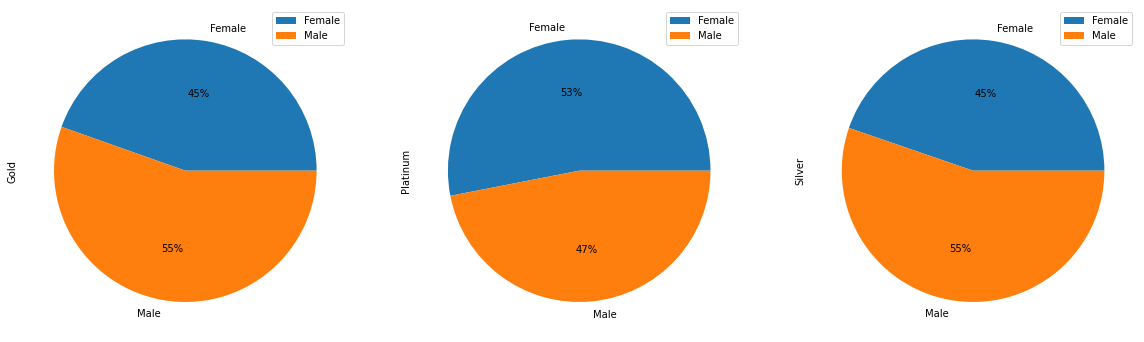

Segment,Gold,Platinum,Silver
gender,,,
Female,2109763.49,2369503.49,1898558.48
Male,2622890.48,2095815.49,2346665.98


In [29]:
# Aggregating the data using crosstab
agg_data = pd.crosstab(final_data.gender,final_data.Segment,values=final_data.claim_amount,aggfunc='sum')

# ploting the pie chart
agg_data.plot(kind='pie',autopct="%1.0f%%",figsize=(20,10),subplots=True)

plt.show()

agg_data

### Among males and females, which gender had claimed the most for any type of driver related issues? E.g. This metric can be compared using a bar chart

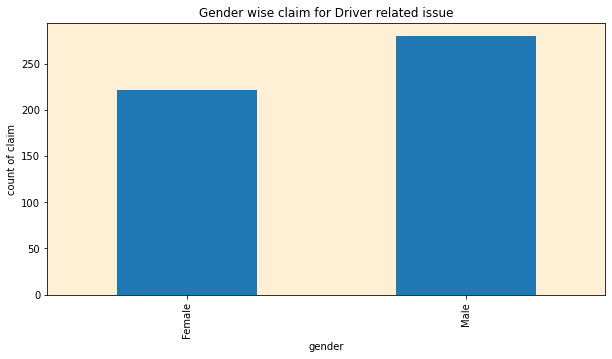

In [30]:
# Aggregating the data under "claim"
claim = final_data.loc[(final_data.incident_cause.str.lower().str.contains("driver"))].groupby(by='gender')['gender'].count()

# Changing the color of the plot
ax = plt.axes()
ax.set_facecolor("papayawhip")

# Creating the plot
Total_sale = claim.plot(kind='bar',figsize=(10,5),width=0.5)

y=['{:,.0f}'.format(x) for x in Total_sale.get_yticks()]
Total_sale.set_yticklabels(y)

plt.ylabel('count of claim')
plt.title('Gender wise claim for Driver related issue')

plt.show()

### Which age group had the maximum fraudulent policy claims? Visualize it on a bar chart.

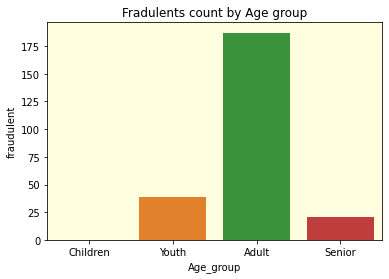

In [31]:
# Aggregating the data under "frauds"
frauds = final_data.loc[final_data['fraudulent'] == 'Yes'].groupby(by='Age_group')['fraudulent'].count().reset_index()

# Changing the color of the plot
ax = plt.axes()
ax.set_facecolor("lightyellow")

# Creating the plot
sns.barplot(data=frauds,x='Age_group',y='fraudulent')

plt.title('Fradulents count by Age group')

plt.show()


### Visualize the monthly trend of the total amount that has been claimed by the customers. Ensure that on the “month” axis, the month is in a chronological order not alphabetical order.

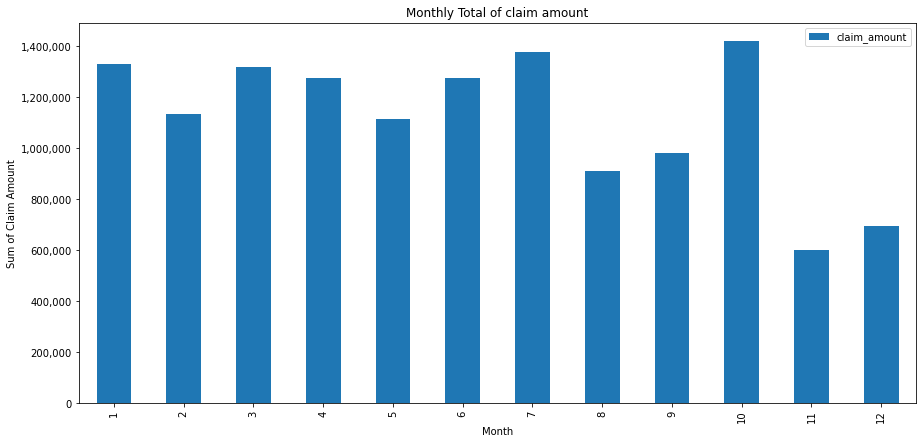

In [32]:
# Aggregating the data under "month_wise"
month_wise = final_data.groupby(by=final_data['claim_date'].dt.month)['claim_amount'].sum().reset_index()

# Changing the column name
month_wise = month_wise.rename(columns={'claim_date':'Month'})

# Setting the Index
month_wise = month_wise.set_index('Month')

# Creating the plot
Total_claim = month_wise.plot(kind='bar',figsize=(15,7))

y=['{:,.0f}'.format(x) for x in Total_claim.get_yticks()]

Total_claim.set_yticklabels(y)

plt.ylabel('Sum of Claim Amount')

plt.title('Monthly Total of claim amount')

plt.show()

### What is the average claim amount for gender and age categories and suitably represent the above using a facetted bar chart, one facet that represents fraudulent claims and the other for non-fraudulent claims.

In [33]:
# Aggregating the data under "data_agg"
data_agg = final_data.groupby(by=['Age_group','gender','fraudulent'])['claim_amount'].agg({'mean'}).reset_index()

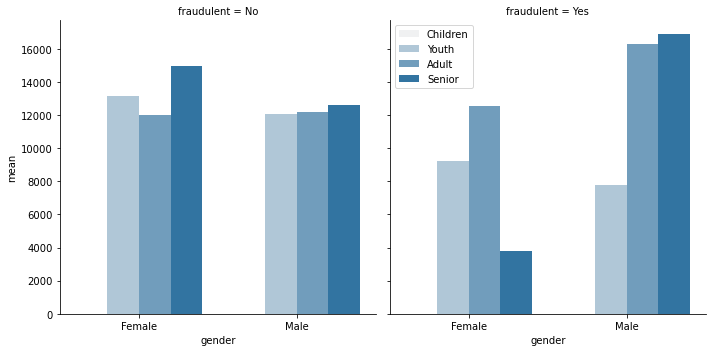

In [34]:
# plotting the data using a facetted chart
plot = sns.FacetGrid(data=data_agg, col='fraudulent',margin_titles=True, height=5)
sns.set_palette("deep")
hue_order = ['Children','Youth','Adult','Senior']
plot.map(sns.barplot,'gender','mean','Age_group',hue_order=hue_order,)
plt.legend()
plt.ticklabel_format(style='plain', axis='y')
plt.show()

## Based on the conclusions from exploratory analysis as well as suitable statistical tests, answer the below questions. Please include a detailed write-up on the parameters taken into consideration, the Hypothesis testing steps, conclusion from the p-values and the business implications of the statements.

### Is there any similarity in the amount claimed by males and females?

Findings :- As the significance value is greater than 0.05, So we fail to reject to null hypothesis.

We can conclude that there is similartity between the amounts claimed by Male & Female

In [35]:
# Aggregating the data under "Male_claim" & "Female_claim"
Male_claim = final_data.loc[final_data['gender'] == 'Male','claim_amount']

Female_claim = final_data.loc[final_data['gender'] == 'Female','claim_amount']

In [37]:
#Ho = u1 = u2
#Ha = u1 <> u2

# C.I. = 95
# P = 0.05

# conducting the statistical test required
print(stats.f_oneway(Male_claim,Female_claim))
print(stats.ttest_ind(Male_claim,Female_claim))

F_onewayResult(statistic=0.7829955562662301, pvalue=0.3764242430542767)
Ttest_indResult(statistic=0.8848703612768547, pvalue=0.3764242430541366)


### Is there any relationship between age category and segment?

Findings :- As Pvalue is greater than 0.05, So we fail to reject the null hypothesis.

So there is no relationship between Age group & Segment

In [38]:
# Aggregating the data under "sorted_data"
sorted_data = pd.crosstab(final_data.Age_group,final_data.Segment)

In [39]:
#Ho = There is no relation between Age category & segment.
#Ha = There is a relation between Age category & segment.

# C.I. = 95
# P = 0.05

# conducting the statistical test required
Chi_test = stats.chi2_contingency(sorted_data)

print("The chi square stat is {} and the p value is {}".format(Chi_test[0],Chi_test[1]))

The chi square stat is 0.6654696397990999 and the p value is 0.9555179463691874


### The current year has shown a significant rise in claim amounts as compared to 2016-17 fiscal average which was $10,000.

Findings:- As Pvalue is greater than 0.05, So we fail to reject the null hypothesis.

Therefore we can say that there is arise in claim amounts as compaired to last year of which average claim amount is $10000

In [40]:
# Aggregating the data under "current_year"
current_year = final_data.loc[final_data['claim_date'].dt.year == 2018,'claim_amount']

In [47]:
# Getting the Mean for Current data
print('The mean of claim amount for current year is',current_year.mean())

The mean of claim amount for current year is 12687.266007597706


In [48]:
#Ho = u1 > 10000
#Ha = u1 <= 10000

# C.I. = 95
# P = 0.05

# conducting the statistical test required
test = stats.ttest_1samp(current_year,10000)

print("The T test stat is {} and the p value is {}".format(test[0],test[1]))

The T test stat is 4.3712566323904385 and the p value is 1.515517575179911e-05


### Is there any difference between age groups and insurance claims?

Findings :- As significance value is greater than 0.05.

Therefore we can say that there is a difference between Age group & Insurance claims

In [43]:
# Aggregating the data under "Youth","Adult" & "Senior"

Youth = final_data.loc[final_data['Age_group'] == "Youth"]['claim_amount']

Adult = final_data.loc[final_data['Age_group'] == "Adult"]['claim_amount']

Senior = final_data.loc[final_data['Age_group'] == "Senior"]['claim_amount']

In [44]:
# Getting the Mean
print('Average of Youth:',Youth.mean(),'| Average of Adult:',Adult.mean(),' | Average of Senior:',Senior.mean())           

Average of Youth: 11848.764309173055 | Average of Adult: 12650.741433068226  | Average of Senior: 12284.199842053304


In [45]:
#Ho = samples are from same population
#Ha = samples are from different population

# C.I. = 95
# P = 0.05

# conducting the statistical test required
test = stats.f_oneway(Youth,Adult,Senior)

print("The F/ANOVA test stat is {} and the p value is {}".format(test[0],test[1]))

The F/ANOVA test stat is 0.30422099875335984 and the p value is 0.7377613078348753


### Is there any relationship between total number of policy claims and the claimed amount?

Findings :- As the Pvalue is higher than 0.05 & we can see that there is a negative correlation.

Therefore we can say that Total number of policy claim & claim amount is inversly proptional to each other.

In [46]:
# Ho: No corelation, independant
# Ha: variables are related, dependant
   
# CI: 95%
# p: 0.05

# conducting the statistical test required
test = stats.spearmanr(final_data.total_policy_claims,final_data.claim_amount)
test2 = final_data.total_policy_claims.corr(other= final_data.claim_amount)


print("The Spearman correlation is {} and the p value is {}".format(test[0],test[1]))
print("The correlation value between total policy claim & total amount is",test2)

The Spearman correlation is 0.009932140236426657 and the p value is 0.7446280619147078
The correlation value between total policy claim & total amount is -0.014291136186627376
